In [8]:
import torch

def find_grid_points(x, n):
    num_segments = 2**n - 1
    segment_length = 2 / num_segments

    # Ensure x is a torch tensor
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float64)

    # Validate that x is in the range [-1, 1]
    if torch.any(x < -1) or torch.any(x > 1):
        raise ValueError("Input x must be in the range [-1, 1]")

    # Calculate the position for each x
    position = ((x + 1) / segment_length).floor()

    # Determine the grid points
    left_point = -1 + position * segment_length
    right_point = left_point + segment_length

    return left_point, right_point, position

# Example usage
x = torch.tensor([-1.0, -0.99, 0.0, -0.3, 0.9, 1.0])
n = 3
left_points, right_points, position = find_grid_points(x, n)
print("Left Points:", left_points)
print("Right Points:", right_points)
print("Position:", position)

Left Points: tensor([-1.0000, -1.0000, -0.1429, -0.4286,  0.7143,  0.7143])
Right Points: tensor([-0.7143, -0.7143,  0.1429, -0.1429,  1.0000,  1.0000])
Position: tensor([0., 0., 3., 2., 6., 6.])


In [9]:
import torch

import torch

def sawtooth_vector(x, n):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float64)

    if torch.any(x < -1) or torch.any(x > 1):
        raise ValueError("Input x must be in the range [-1, 1]")

    num_elements = 2 ** n
    num_x = x.shape[0]
    vector = torch.zeros(num_x, num_elements, dtype=torch.float64)

    # Initialize the vector with the first two entries
    vector[:, 0] = torch.sqrt(0.5 * (1 + x))
    vector[:, 1] = torch.sqrt(0.5 * (1 - x))

    count = 2
    for k in range(1, 2**(n-1), 1):
        left_node, right_node, position = find_grid_points(x, k+1)

        sawtooth_up = (x - left_node) / (right_node - left_node)
        sawtooth_down = (right_node - x) / (right_node - left_node)
        sawtooth_up = torch.sqrt(sawtooth_up)
        sawtooth_down = torch.sqrt(sawtooth_down)

        for i in range(num_x):
            odd = position[i].long() % 2
            if not odd:
               vector[i, count] = sawtooth_up[i]
               vector[i, count+1] = sawtooth_down[i]
            else:
               vector[i, count] = sawtooth_down[i]
               vector[i, count+1] = sawtooth_up[i]
                
        count += 2

    return vector


# Example usage
x = torch.tensor([0.5])
n = 3
print(sawtooth_vector(x, n))
print(sawtooth_vector(x, n).shape)

tensor([[0.8660, 0.5000, 0.5000, 0.8660, 0.8660, 0.5000, 0.8660, 0.5000]],
       dtype=torch.float64)
torch.Size([1, 8])


In [13]:
import numpy as np
import torch

def linear_FEM_basis(x, n):
    num_nodes = 2 ** n
    nodes = np.linspace(-1, 1, num_nodes)
    nodes = torch.tensor(nodes, dtype=torch.float64)

    # Initialize the output tensor
    values = torch.zeros(x.shape[0], num_nodes, dtype=torch.float64)
    
    # Distance between nodes
    h = 2 / (num_nodes - 1)

    # Handle tensor input for x
    for i in range(1, num_nodes):
        mask = (nodes[i - 1] <= x) & (x <= nodes[i])
        values[mask, i - 1] = (nodes[i] - x[mask]) / h
        values[mask, i] = (x[mask] - nodes[i - 1]) / h

    #values = torch.sqrt(values)
    norms = torch.linalg.norm(values, dim=1, keepdim=True)
    #values /= norms
    return values.squeeze(0), norms

# Example usage with tensor input
x_tensor = torch.tensor([-1.0, -0.99, -0.9, 0.0, 0.125, 1.0], dtype=torch.float64)
x_tensor = torch.tensor([-1.0, -0.99, 0.0, -0.3, 0.9, 1.0], dtype=torch.float64)
n = 3
result, _ = linear_FEM_basis(x_tensor, n)
print(result)
print(result.shape)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9650, 0.0350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5500, 0.4500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3500, 0.6500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]],
       dtype=torch.float64)
torch.Size([6, 8])


In [3]:
from qulearn.hat_basis import HatBasis
import torch
a = -1.0
b = 1.0
num_qubits = 3
num_nodes = 6
hb = HatBasis(a, b, num_nodes)
x = torch.tensor([-1.0, -0.99, 0.0, -0.3, 0.9, 1.0], dtype=torch.float64)
vals = hb.eval_basis_vector(x)

print(vals)
print(hb.position(x))
print(hb.grid_points(x))

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9750, 0.0250, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.7500, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.7500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]], dtype=torch.float64)
tensor([0., 0., 2., 1., 4., 5.], dtype=torch.float64)
(tensor([-1.0000, -1.0000, -0.2000, -0.6000,  0.6000,  1.0000],
       dtype=torch.float64), tensor([-0.6000, -0.6000,  0.2000, -0.2000,  1.0000,  1.4000],
       dtype=torch.float64))


In [2]:
print(2*0.7071**2)
print(2*0.7071**2)

0.9999808199999999
0.9999808199999999


tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
torch.Size([1000, 1])


IndexError: index 9 is out of bounds for axis 0 with size 9

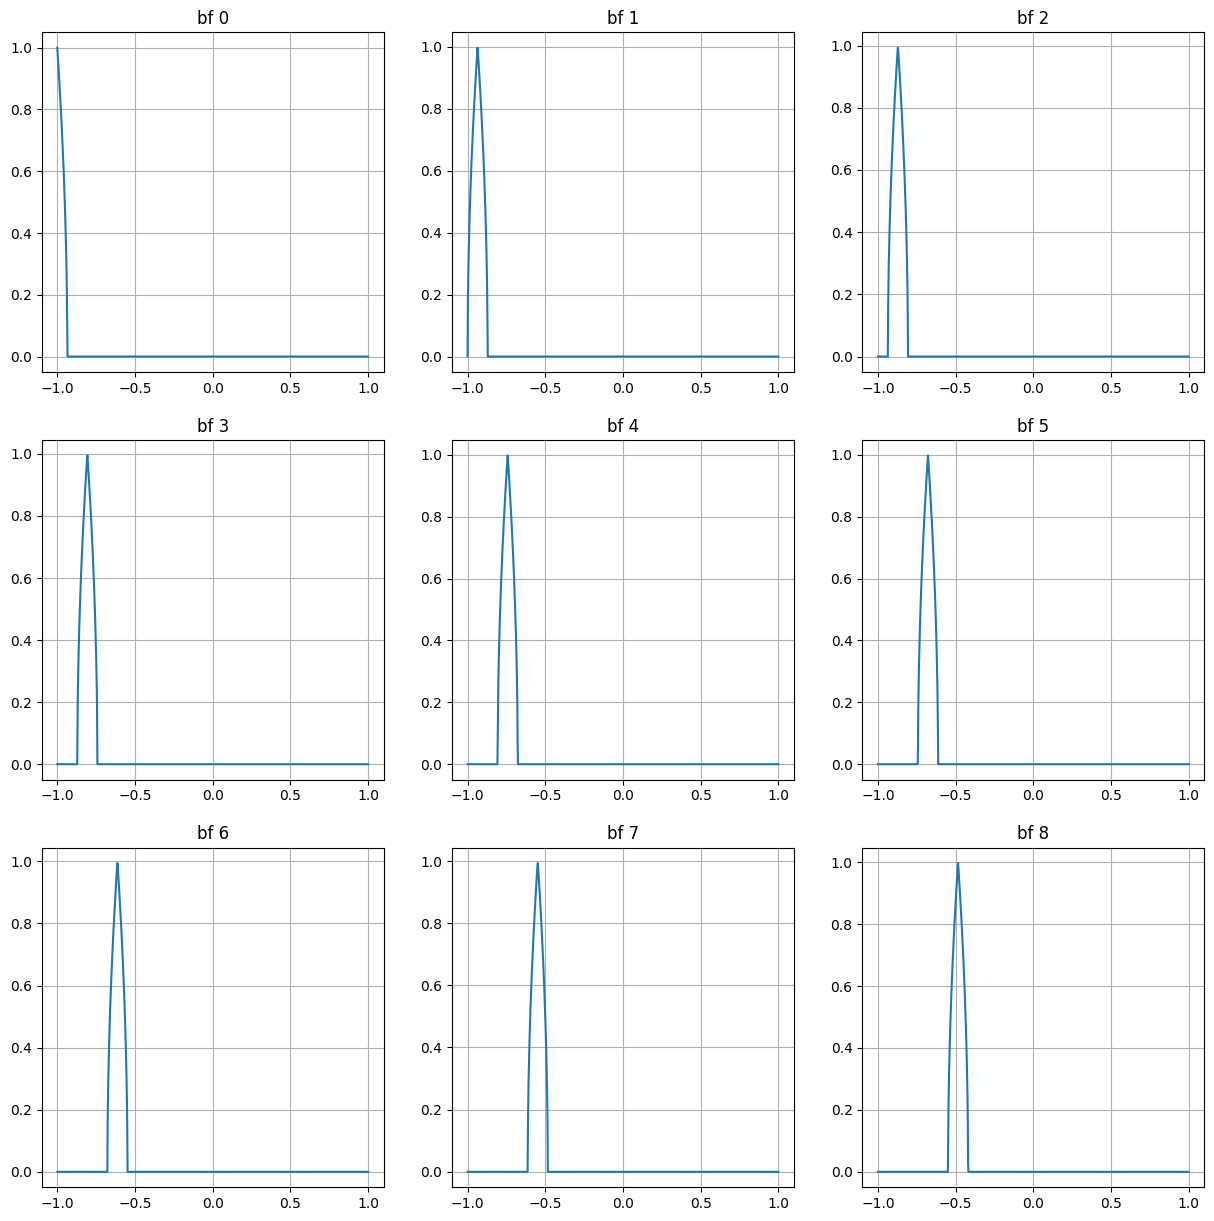

In [3]:
import matplotlib.pyplot as plt
import torch

def plot_basis_combinations(x_values, basis_functions, n):
    grid_size=(3, 3)
    num_plots = grid_size[0] * grid_size[1]
    _, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axs = axs.flatten()

    # Generate all unique combinations of basis functions
    for idx in range(basis_functions.shape[1]):
        axs[idx].plot(x_values, basis_functions[:, idx])
        axs[idx].set_title(f"bf {idx}")
        axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

# Generate x values for plotting
x_plot = torch.tensor(np.linspace(-1, 1, 1000))

# Generate the basis functions for each x in x_plot
basis_functions, norms = linear_FEM_basis(x_plot, n)
print(torch.linalg.norm(basis_functions[0, :]))
print(torch.linalg.norm(basis_functions[10]))
print(torch.linalg.norm(basis_functions[-1]))
print(norms.shape)
#basis_functions = sawtooth_vector(x_plot, n)
plot_basis_combinations(x_plot, basis_functions, n)

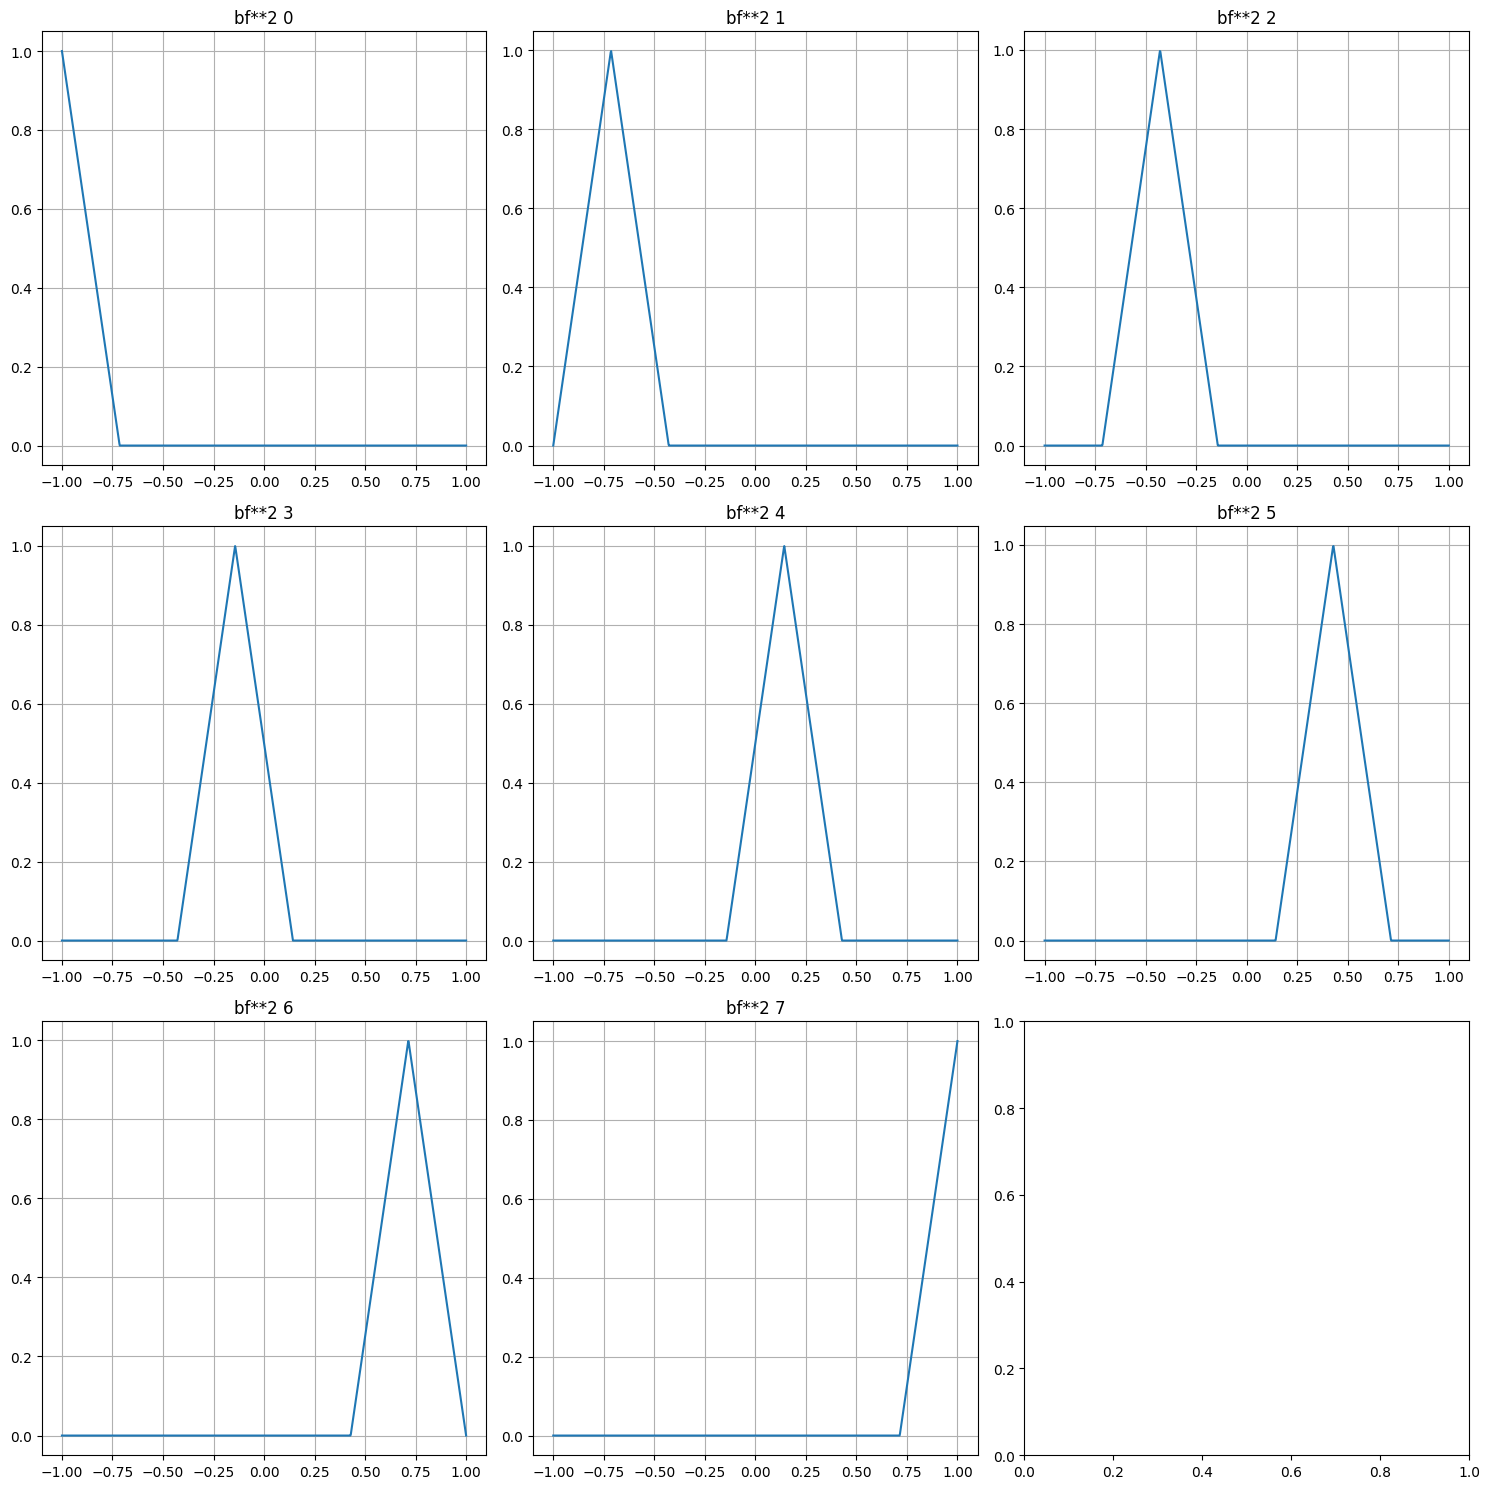

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_basis_combinations(x_values, basis_functions, n):
    grid_size=(3, 3)
    num_plots = grid_size[0] * grid_size[1]
    _, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axs = axs.flatten()

    # Generate all unique combinations of basis functions
    for idx in range(basis_functions.shape[1]):
        bf = basis_functions[:, idx]
        axs[idx].plot(x_values, bf**2)
        axs[idx].set_title(f"bf**2 {idx}")
        axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

# Generate x values for plotting
x_plot = torch.tensor(np.linspace(-1, 1, 1000))

# Generate the basis functions for each x in x_plot
basis_functions, _ = linear_FEM_basis(x_plot, n)
#basis_functions = sawtooth_vector(x_plot, n)
plot_basis_combinations(x_plot, basis_functions, n)

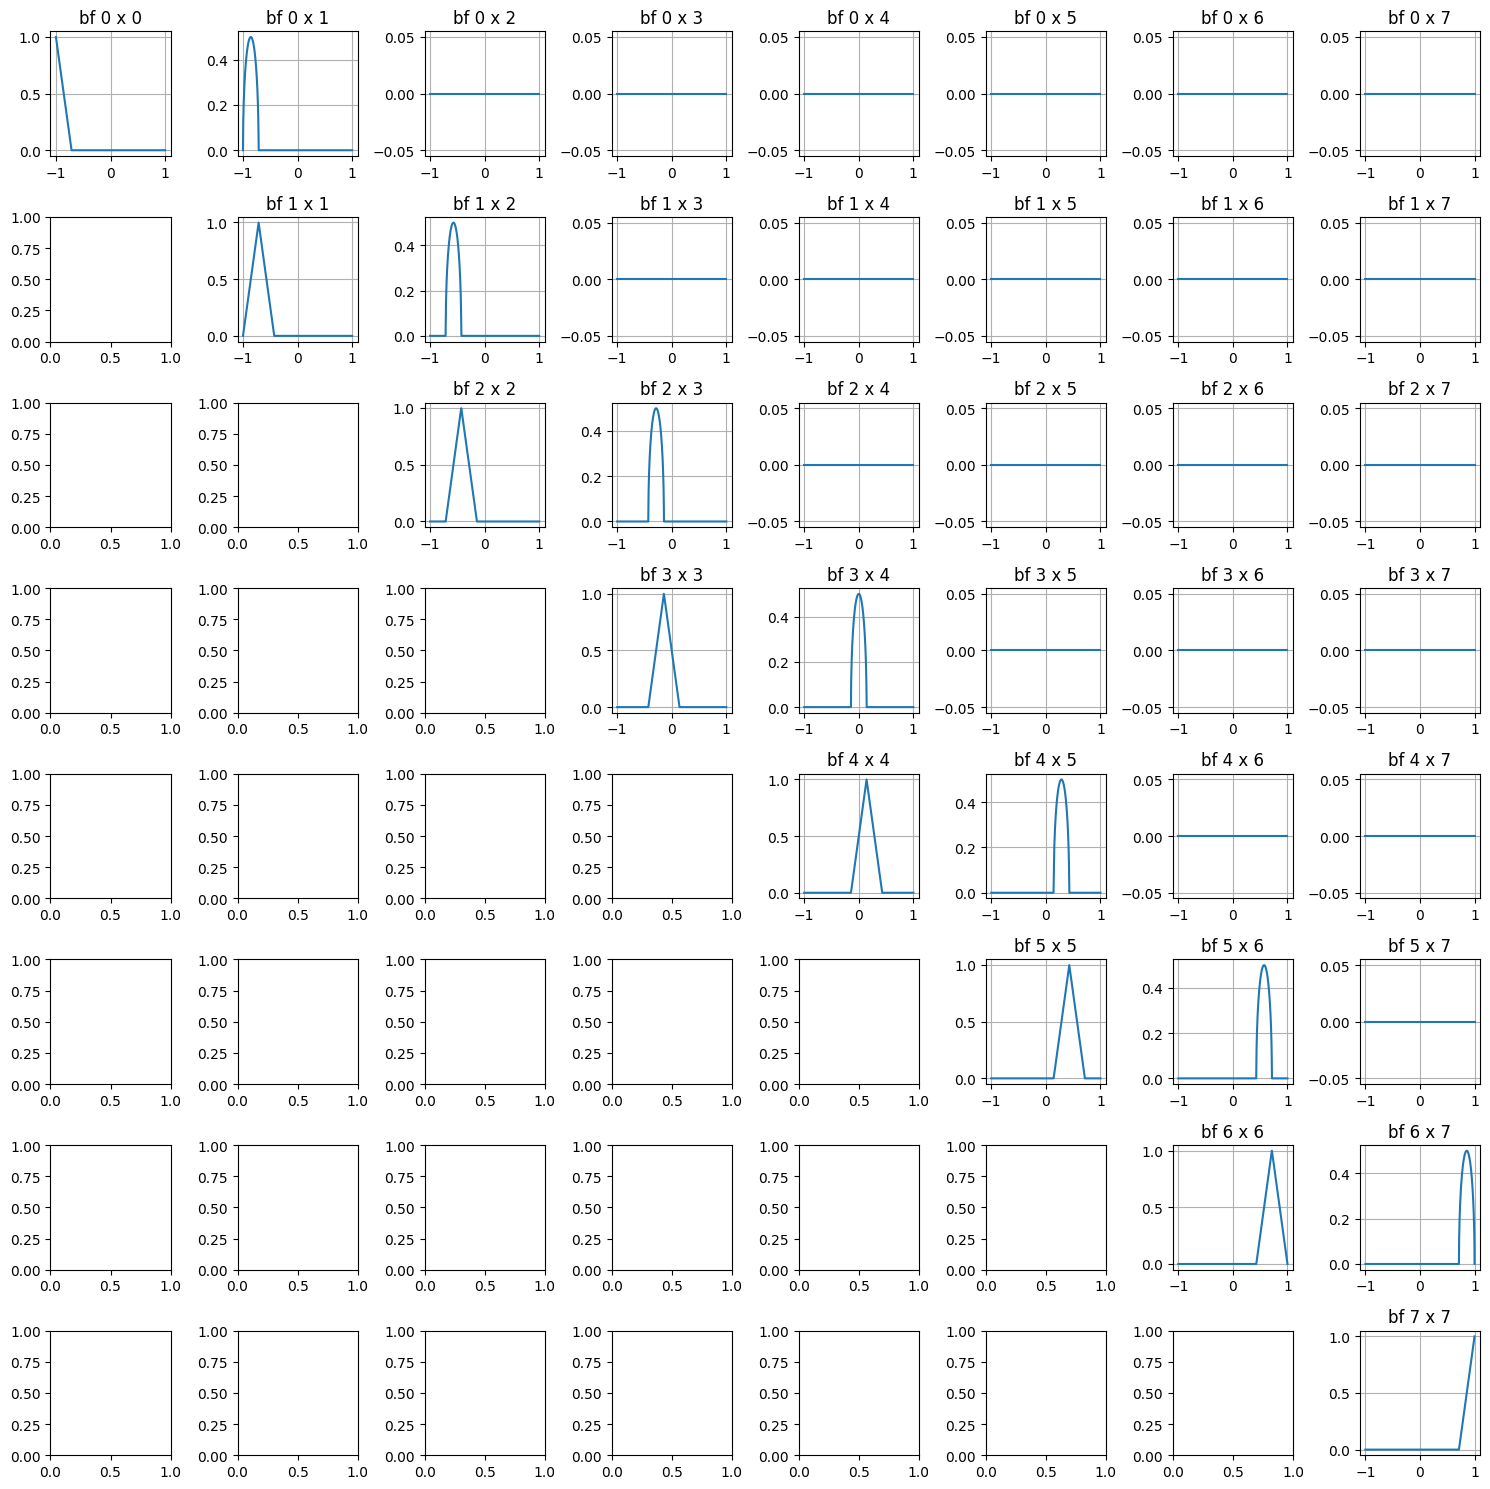

In [ ]:
import matplotlib.pyplot as plt
import torch
import itertools

def plot_basis_combinations(x_values, basis_functions, n):
    s = 2**n
    grid_size=(s, s)
    num_plots = grid_size[0] * grid_size[1]
    _, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

    # Generate all unique combinations of basis functions
    all_combinations = list(itertools.combinations_with_replacement(range(2**n), 2))
    selected_combinations = all_combinations[:num_plots]

    for idx, (i, j) in enumerate(selected_combinations):
        combined_basis = basis_functions[:, i]*basis_functions[:, j]
        axs[i, j].plot(x_values, combined_basis)
        axs[i, j].set_title(f"bf {i} x {j}")
        axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

# Generate x values for plotting
x_plot = torch.tensor(np.linspace(-1, 1, 1000))

# Generate the basis functions for each x in x_plot
basis_functions, _ = linear_FEM_basis(x_plot, n)
#basis_functions = sawtooth_vector(x_plot, n)
plot_basis_combinations(x_plot, basis_functions, n)

In [ ]:
import pennylane as qml
from qulearn import qlayer
import torch


class LinearAmplitudeEmbedding(qlayer.CircuitLayer):
    def __init__(self, num_qubits):
        super().__init__(num_qubits)
        self.num_qubits = num_qubits

    def circuit(self, x):
        Phi, _ = linear_FEM_basis(x, self.num_qubits)
        #Phi = sawtooth_vector(x, self.num_qubits)
        #Phi = Phi / torch.linalg.norm(Phi)
        qml.AmplitudeEmbedding(features=Phi, wires=self.wires, normalize=False)

In [ ]:
import pennylane as qml
from qulearn import qlayer
from torch import nn
import math

class AltRotCRXLayer(qlayer.CircuitLayer):
    def __init__(
        self,
        wires,
        n_layers = 1,
        cdevice = None,
        dtype = None,
    ) -> None:
        super().__init__(wires)

        self.n_layers = n_layers
        self.cdevice = cdevice
        self.dtype = dtype

        # weight parameters
        circ_offset = 1 if self.num_wires > 2 else 0
        
        self.initial_layer_weights = torch.nn.Parameter(
            torch.empty((self.num_wires, 3), device=self.cdevice, dtype=self.dtype)
        )
        
        self.one_qubit_weights = torch.nn.Parameter(
            torch.empty(
                (2*self.n_layers, 2 * (self.num_wires - 1) + 2*circ_offset, 3),
                device=self.cdevice,
                dtype=self.dtype,
            )
        )
        
        self.crx_weights = torch.nn.Parameter(
            torch.empty(
                (self.n_layers, self.num_wires - 1 + circ_offset),
                device=self.cdevice,
                dtype=self.dtype,
            )
        )
        self.xx_weights = torch.nn.Parameter(
            torch.empty(
                (self.n_layers, self.num_wires - 1 + circ_offset),
                device=self.cdevice,
                dtype=self.dtype,
            )
        )
       # nn.init.zeros_(self.initial_layer_weights)
       # nn.init.zeros_(self.one_qubit_weights)
       # nn.init.zeros_(self.two_qubit_weights)
       
        
        nn.init.uniform_(self.initial_layer_weights, a=0.0, b=2 * math.pi)
        nn.init.uniform_(self.one_qubit_weights, a=0.0, b=2 * math.pi)
        nn.init.uniform_(self.crx_weights, a=0.0, b=2 * math.pi)
        nn.init.uniform_(self.xx_weights, a=0.0, b=2 * math.pi)


    def circuit(self, _ = None):
       for index, q in enumerate(self.wires):
            qml.Rot(
                self.initial_layer_weights[index, 0],
                self.initial_layer_weights[index, 1],
                self.initial_layer_weights[index, 2],
                q,
            )

       for layer in range(self.n_layers):
           for i in range(0, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.CRX(self.crx_weights[layer, crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[layer, i, 0],
                   self.one_qubit_weights[layer, i, 1],
                   self.one_qubit_weights[layer, i, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[layer, i + 1, 0],
                   self.one_qubit_weights[layer, i + 1, 1],
                   self.one_qubit_weights[layer, i + 1, 2],
                   self.wires[i + 1],
               )

           offset_1q = (self.num_wires // 2) * 2
           offset_2q = self.num_wires//2
           for i in range(1, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.CRX(self.crx_weights[layer, offset_2q + crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[layer, offset_1q + i - 1, 0],
                   self.one_qubit_weights[layer, offset_1q + i - 1, 1],
                   self.one_qubit_weights[layer, offset_1q + i - 1, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[layer, offset_1q + i, 0],
                   self.one_qubit_weights[layer, offset_1q + i, 1],
                   self.one_qubit_weights[layer, offset_1q + i, 2],
                   self.wires[i + 1],
               )
           
           if self.num_wires > 2: 
               qml.CRX(self.crx_weights[layer, -1], wires=[self.wires[-1], self.wires[0]])
               qml.Rot(
                   self.one_qubit_weights[layer, -2, 0],
                   self.one_qubit_weights[layer, -2, 1],
                   self.one_qubit_weights[layer, -2, 2],
                   self.wires[-1],
               )
               qml.Rot(
                   self.one_qubit_weights[layer, -1, 0],
                   self.one_qubit_weights[layer, -1, 1],
                   self.one_qubit_weights[layer, -1, 2],
                   self.wires[0],
               )



       for layer in range(self.n_layers):
           for i in range(0, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.IsingXX(self.xx_weights[layer, crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, i, 0],
                   self.one_qubit_weights[self.n_layers + layer, i, 1],
                   self.one_qubit_weights[self.n_layers + layer, i, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, i + 1, 0],
                   self.one_qubit_weights[self.n_layers + layer, i + 1, 1],
                   self.one_qubit_weights[self.n_layers + layer, i + 1, 2],
                   self.wires[i + 1],
               )

           offset_1q = (self.num_wires // 2) * 2
           offset_2q = self.num_wires//2
           for i in range(1, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.IsingXX(self.xx_weights[layer, offset_2q + crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i - 1, 0],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i - 1, 1],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i - 1, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i, 0],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i, 1],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i, 2],
                   self.wires[i + 1],
               )
           
           if self.num_wires > 2: 
               qml.IsingXX(self.xx_weights[layer, -1], wires=[self.wires[-1], self.wires[0]])
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, -2, 0],
                   self.one_qubit_weights[self.n_layers + layer, -2, 1],
                   self.one_qubit_weights[self.n_layers + layer, -2, 2],
                   self.wires[-1],
               )
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, -1, 0],
                   self.one_qubit_weights[self.n_layers + layer, -1, 1],
                   self.one_qubit_weights[self.n_layers + layer, -1, 2],
                   self.wires[0],
               )



In [ ]:
import torch
from torch import nn

class LinearFEMModel(nn.Module):
    def __init__(self, n):
        super(LinearFEMModel, self).__init__()
        self.n = n
        self.coefficients = nn.Parameter(torch.randn(2 ** n, dtype=torch.float64))

    def forward(self, x):
        basis, norms = linear_FEM_basis(x, self.n)
        basis *= norms
        return torch.matmul(basis, self.coefficients)

In [ ]:
import torch

class PostMultiply(nn.Module):
    def __init__(self, qnn, num_qubits):
        super(PostMultiply, self).__init__()
        self.qnn = qnn
        self.num_qubits = num_qubits

    def forward(self, x):
        out = self.qnn(x)
        numx = x.shape[0]
        norms = torch.zeros((numx, 1), dtype=torch.float64)
        for k in range(numx):
            _, norm = linear_FEM_basis(x[k,:], self.num_qubits)
            norms[k, 0] = norm
            
        out /= norms
        
        print("out: ", out)
        print("norms: ", norms)
        
        return out

In [ ]:
from qulearn import qlayer
import pennylane as qml
import torch
from torch import nn
import itertools


num_qubits = 5
embed = LinearAmplitudeEmbedding(num_qubits)
n_layers = 0
hads = qlayer.HadamardLayer(num_qubits)
var1 = qlayer.AltRotCXLayer(wires=num_qubits, n_layers=n_layers)
var2 = qlayer.AltRotCXLayer(wires=num_qubits, n_layers=n_layers)
var3 = AltRotCRXLayer(num_qubits, n_layers=n_layers)

#var3.initial_layer_weights = var1.initial_layer_weights
#var3.one_qubit_weights = var1.weights
var1.initial_layer_weights = var3.initial_layer_weights
var1.weights = var3.one_qubit_weights


hads = qlayer.HadamardLayer(num_qubits)
obs = qml.PauliZ(0)
obs1 = qml.PauliZ(0)
obs2 = qml.PauliZ(1)
obs3 = qml.PauliZ(2)
obs = [qml.Identity(0)] + [qml.PauliX(j) for j in range(num_qubits)]
#obs1 = qml.Hermitian(D, wires=range(num_qubits))
obs = ([qml.Identity(0)] + [qml.PauliZ(j)@qml.PauliZ(j+1) for j in range(num_qubits-1)]
+[qml.PauliX(j)@ qml.PauliX(j+1) for j in range(num_qubits-1)]
+[qml.PauliY(j)@ qml.PauliY(j+1) for j in range(num_qubits-1)]
+[qml.PauliZ(j) for j in range(num_qubits)])
obs1 = qml.Projector(basis_state=[0, 0, 0, 0, 0], wires=range(num_qubits))
obs2 = qml.Projector(basis_state=[1, 1, 1, 1, 1], wires=range(num_qubits))
obs = [qml.PauliZ(0)]

class CombinedModel(nn.Module):
    def __init__(self, *models):
        super(CombinedModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.randn(len(models)))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        outputs = [model(x) * weight for model, weight in zip(self.models, self.weights)]
        return sum(outputs) + self.bias
    
def generate_bitstrings(n):
    return list(itertools.product([0, 1], repeat=n))

#qdev = qml.device(wires=num_qubits, name="lightning.qubit")
qdev = qml.device(wires=num_qubits, name="default.qubit")
#diff_method = "adjoint"
diff_method = "backprop"

def create_models(bitstrings, embed, var, num_qubits):
    models = []
    for bitstring in bitstrings:
        obs = qml.Projector(basis_state=list(bitstring), wires=range(num_qubits))
        model = qlayer.MeasurementLayer(embed, var, observables=obs, measurement_type=qlayer.MeasurementType.Expectation, qdevice=qdev, diff_method=diff_method)
        models.append(model)
    return models

def create_models_1q(embed, var, num_qubits):
    models = []
    for q in range(num_qubits):
        obs = qml.Projector(basis_state=[0], wires=[q])
        model = qlayer.MeasurementLayer(embed, var, observables=obs, measurement_type=qlayer.MeasurementType.Expectation, qdevice=qdev, diff_method=diff_method)
        models.append(model)
        obs = qml.Projector(basis_state=[1], wires=[q])
        model = qlayer.MeasurementLayer(embed, var, observables=obs, measurement_type=qlayer.MeasurementType.Expectation, qdevice=qdev, diff_method=diff_method)
        models.append(model)
    return models

states = generate_bitstrings(num_qubits)
models = create_models_1q(embed, var3, num_qubits)
combined_model = CombinedModel(*models)


#embed = qlayer.ParallelIQPEncoding(num_qubits, num_features=1, n_repeat=1, base=3.0, omega=1.0)
model1 = qlayer.MeasurementLayer(embed, var3, observables=obs1, measurement_type=qlayer.MeasurementType.Expectation)
model1 = qlayer.MeasurementLayer(embed, observables=obs1, measurement_type=qlayer.MeasurementType.Expectation)
model2 = qlayer.MeasurementLayer(embed, var3, observables=obs2, measurement_type=qlayer.MeasurementType.Expectation)
model3 = qlayer.MeasurementLayer(embed, var3, observables=obs3, measurement_type=qlayer.MeasurementType.Expectation)
model = qlayer.HamiltonianLayer(embed, var1, observables=obs, qdevice=qdev, diff_method=diff_method)
model1 = qlayer.MeasurementLayer(embed, hads, var1, observables=obs1, qdevice=qdev, diff_method=diff_method, measurement_type=qlayer.MeasurementType.Expectation)
model2 = qlayer.MeasurementLayer(embed, hads, var1, observables=obs2, qdevice=qdev, diff_method=diff_method, measurement_type=qlayer.MeasurementType.Expectation)
#pmodel = PostMultiply(model, num_qubits)

drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.rand((1), dtype=torch.float64)
print(drawer(x))

x = torch.tensor([[0.0], [0.124]], dtype=torch.float64)
print(model(x).shape)
print(model(x))
#model = LinearFEMModel(num_qubits)
#model = CombinedModel(model1, model2)

0: ─╭QubitStateVector(M0)──Rot(2.42,0.96,6.12)─┤  <𝓗(-2.50)>
1: ─├QubitStateVector(M0)──Rot(1.07,3.21,4.06)─┤            
2: ─├QubitStateVector(M0)──Rot(1.74,5.69,4.00)─┤            
3: ─├QubitStateVector(M0)──Rot(4.42,4.18,4.04)─┤            
4: ─╰QubitStateVector(M0)──Rot(2.29,0.72,6.19)─┤            
torch.Size([2, 1])
tensor([[-2.2204e-16],
        [ 1.4323e+00]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)


torch.Size([200, 1])


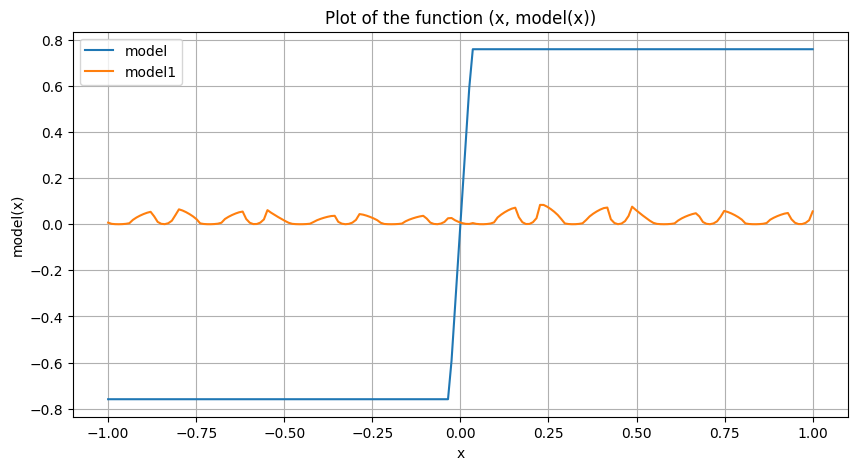

In [ ]:
import torch
import matplotlib.pyplot as plt

a = 1
x_values = torch.linspace(-a, a, steps=200, dtype=torch.float64).reshape(-1, 1)
print(x_values.shape)

with torch.no_grad():
    y_values = model(x_values)
    y1 = model1(x_values)
    y2 = model2(x_values)
    y3 = model3(x_values)

# Convert to numpy for plotting
x_values_np = x_values.numpy()
y_values_np = y_values.squeeze().numpy()
y1 = y1.squeeze().numpy()
y2 = y2.squeeze().numpy()
y3 = y3.squeeze().numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_values_np, y_values_np, label="model")
plt.plot(x_values_np, y1, label="model1")
#plt.plot(x_values_np, y2, label="model2")
#plt.plot(x_values_np, y3, label="model3")
plt.xlabel("x")
plt.ylabel("model(x)")
plt.title("Plot of the function (x, model(x))")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch

# Generate a sample of inputs
X = torch.linspace(-1, 1, 1000).reshape(-1, 1)


# Define a function to add Gaussian noise
def add_gaussian_noise(tensor, mean=0.0, std=0.01):
    return tensor + torch.randn(tensor.size()) * std + mean


# 1. Linear Relationship
def linear(X, m=2, c=3):
    return m * X + c


Y_linear = add_gaussian_noise(linear(X))


# 2. Polynomial Relationship (Quadratic for demonstration)
def polynomial(X, a=3, b=2, c=-5):
    return a * X**2 + b * X + c


Y_polynomial = add_gaussian_noise(polynomial(X))


# 3. Exponential Relationship
def exponential(X, a=2, b=0.5):
    return a * torch.exp(b * X)


Y_exponential = add_gaussian_noise(exponential(X))


# 4. Logarithmic Relationship
def logarithmic(X, a=3, b=2):
    return a * torch.log(X) + b


Y_logarithmic = add_gaussian_noise(logarithmic(X))


# 5. Trigonometric Relationship
def trigonometric(X, a=5, b=2, c=0.5):
    return a * torch.sin(b * X + c)


Y_trigonometric = add_gaussian_noise(trigonometric(X))


# 6. Power-law Relationship
def power_law(X, a=2, b=1.5):
    return a * X**b


Y_power_law = add_gaussian_noise(power_law(X))


# 7. Sigmoidal Relationship
def sigmoidal(X, L=1, k=0.5, x0=5):
    return L / (1 + torch.exp(-k * (X - x0)))


Y_sigmoidal = add_gaussian_noise(sigmoidal(X))


# 8. Gaussian Relationship
def gaussian(X, a=1.0, b=0, c=1):
    return a * torch.exp(-((X - b) ** 2) / (2 * c**2))


Y_gaussian = add_gaussian_noise(gaussian(X))


# 9. Step Function
def step_function(
    X, threshold1=-0.0323, threshold2=1.5, low_value=2, mid_value=-2, high_value=-0.25
):
    condition1 = X < threshold1
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = X >= threshold2

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value

    return values


Y_step = add_gaussian_noise(step_function(X))


def piecewise_linear_3segments(X, a=-0.714, b=0.143, m1=2, c1=0, m2=-3, m3=1):
    # Define linear functions for each segment
    linear_before_a = m1 * X + c1
    linear_between_a_b = m1 * a + c1 + m2 * (X - a)
    linear_after_b = m1 * a + c1 + m2 * (b - a) + m3 * (X - b)

    # Apply conditions for each segment
    conditions = [(X < a), (X >= a) & (X < b), (X >= b)]
    functions = [linear_before_a, linear_between_a_b, linear_after_b]

    output = torch.zeros_like(X)
    for condition, function in zip(conditions, functions):
        output[condition] = function[condition]

    return output


Y_piecewise_spiked = add_gaussian_noise(piecewise_linear_3segments(X))


def multidimstep(X, a=1.0):
    # Extract the first and second features
    X0 = X[:, 0]
    X1 = X[:, 1]

    # Check the condition X[1] > a * X[0]
    condition = X1 > a * X0

    # Initialize the output tensor Y
    Y = torch.zeros_like(X1)

    # Set Y values based on the condition
    Y[condition] = 1  # Set to +1 where condition is True
    Y[~condition] = -1  # Set to -1 where condition is False

    return Y.view(-1, 1)  # Reshape to make it a column vector


def high_low(X, low=1.0, high=30.0):
    return torch.sin(low * X) + 0.5 * torch.sin(high * X)


Y_high_low = add_gaussian_noise(high_low(X))

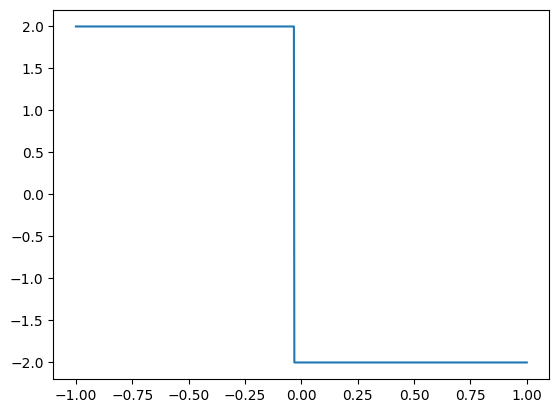

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot
func = step_function
func = gaussian
func = piecewise_linear_3segments
func = step_function
sigma = 0.0
Y = add_gaussian_noise(func(X), std=sigma)
plt.plot(X, Y)

# Show the plot
plt.show()

In [ ]:
import torch
import logging
from torch.optim import Adam
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset

# Data
N_train = 50
N_valid = 5
batch_size = 25
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import logging
from torch.optim import Adam, LBFGS
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.regression import MeanAbsolutePercentageError

# Trainer
lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
metric = MeanAbsolutePercentageError()

In [ ]:
logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [ ]:
# Train
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 8.342393, Metrics: MARE: 1.440194
INFO:train_function:Validate - Epoch: 1, Loss: 7.607440, Metrics: MARE: 1.366828
INFO:train_function:Train - Epoch: 2, Loss: 5.895769, Metrics: MARE: 1.212957
INFO:train_function:Validate - Epoch: 2, Loss: 5.577182, Metrics: MARE: 1.177464
INFO:train_function:Train - Epoch: 3, Loss: 4.131848, Metrics: MARE: 1.016340
INFO:train_function:Validate - Epoch: 3, Loss: 4.109858, Metrics: MARE: 1.013616
INFO:train_function:Train - Epoch: 4, Loss: 2.913098, Metrics: MARE: 0.852639
INFO:train_function:Validate - Epoch: 4, Loss: 3.092991, Metrics: MARE: 0.877199
INFO:train_function:Train - Epoch: 5, Loss: 2.072767, Metrics: MARE: 0.716553
INFO:train_function:Validate - Epoch: 5, Loss: 2.389320, Metrics: MARE: 0.763794
INFO:train_function:Train - Epoch: 6, Loss: 1.476303, Metrics: MARE: 0.599679
INFO:train_function:Validate - Epoch: 6, Loss: 1.887640, Metrics: MARE: 0.666399
INFO:train_function:Train - Epoch: 7, Loss: 1.

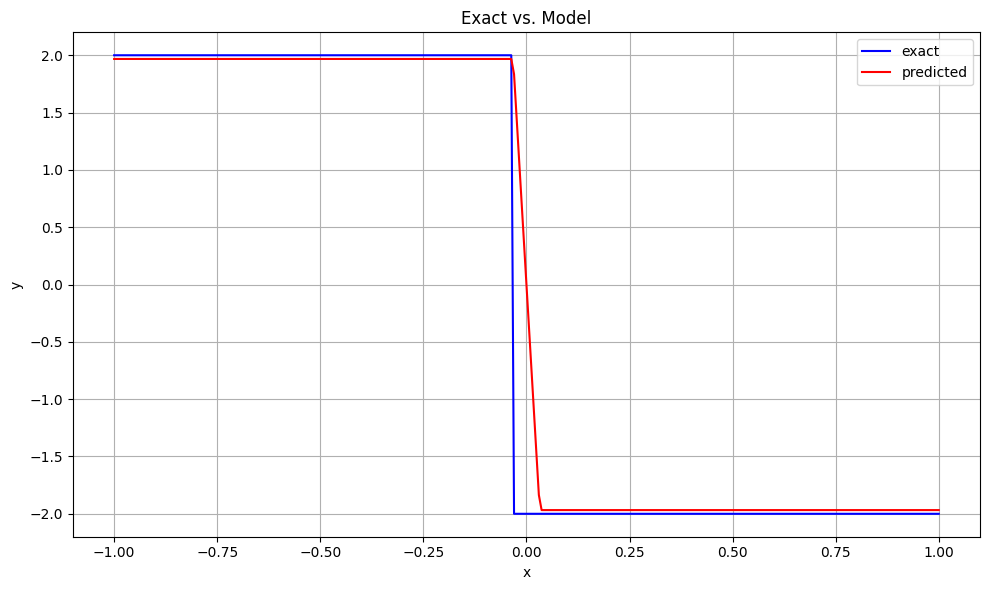

In [ ]:
# Plotting
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")

# Adding title and labels
plt.title("Exact vs. Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(model.observable_weights)

Parameter containing:
tensor([-1.9678], requires_grad=True)


In [ ]:
import torch
print(model.coefficients)
D = torch.diag(model.coefficients)
D = D.type(torch.complex64)
print(D)

Parameter containing:
tensor([0.6115, 0.7766, 0.9200, 1.0011, 0.9861, 0.9143, 0.7843, 0.6087],
       dtype=torch.float64, requires_grad=True)
tensor([[0.6115+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j],
        [0.0000+0.j, 0.7766+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.9200+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 1.0011+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.9861+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.9143+0.j, 0.0000+0.j,
         0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.7843+0.j,
         0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+

In [ ]:
import torch
from qulearn import qlayer
import pennylane as qml

n_layers = 3
num_qubits = 2
layer = qlayer.AltRotCXLayer(num_qubits, n_layers)

dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def circuit():
    layer.circuit()
    return qml.sample(wires=range(num_qubits))

drawer = qml.draw(circuit)
print(drawer())

U = qml.matrix(layer.circuit)()
print(U)

0: ──Rot(5.12,2.71,1.30)─╭●──Rot(2.72,4.57,1.35)─╭●──Rot(4.07,5.89,0.10)─╭●──Rot(2.49,5.49,3.95)─┤
1: ──Rot(3.05,2.99,3.77)─╰X──Rot(1.46,4.08,1.75)─╰X──Rot(3.79,4.54,1.10)─╰X──Rot(2.56,2.23,5.75)─┤

  ╭Sample
  ╰Sample
tensor([[-0.1825-0.5123j, -0.5127-0.1049j,  0.0955-0.1297j, -0.2530-0.5834j],
        [-0.1597-0.0348j,  0.3080-0.6627j,  0.3754-0.1744j, -0.4636+0.2302j],
        [ 0.0107-0.7958j,  0.0552+0.1769j,  0.0404+0.1368j,  0.0945+0.5504j],
        [-0.1716+0.1210j, -0.2968-0.2639j, -0.0368+0.8837j, -0.0871+0.0909j]],
       grad_fn=<MmBackward0>)


In [ ]:
O = U @ D @ U.conj().t()
print(D)

tensor([[0.6136+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.9758+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.9746+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.6154+0.j]],
       grad_fn=<ToCopyBackward0>)
